# Chat Intents

## UMAP + HDBSCAN

**Summary**

This notebook outlines a way to automatically determine the best hyperparameters for UMAP + HDBSCAN. See the `chatintents_tutorial.ipynb` notebook for a tutorial of the chatintents package, which simplifies and makes it easier to use the methods outlined below.


In [1]:
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import umap
import tensorflow as tf

import tensorflow_hub as hub

from sentence_transformers import SentenceTransformer

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

In [2]:
pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

## Load data and pre-trained models

In [3]:
# data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample = pd.read_csv('phrases.csv')


data_sample.head()

,Unnamed: 0,0
0,0,place
1,1,Crust
2,2,texture
3,3,selection
4,4,menu


In [4]:
all_intents = list(data_sample['0'])
len(all_intents)

1188

In [5]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

OSError: SavedModel file does not exist at: /var/folders/2s/cw9c987d63b88hr6z92b07840000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c/{saved_model.pbtxt|saved_model.pb}

In [10]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('all-distilroberta-v1')

In [11]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [12]:
embeddings_use = embed(model_use, 'use', all_intents)

In [13]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

In [14]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

In [15]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

In [16]:
embeddings = [embeddings_use, embeddings_st1, embeddings_st2, embeddings_st3]

for embedding in embeddings:
    print(embedding.shape)

(1188, 512)
(1188, 768)
(1188, 384)
(1188, 768)


In [17]:
all_intents

['place',
 'Crust',
 'texture',
 'selection',
 'menu',
 'prices',
 'pho',
 'potatoes',
 'fries',
 'touch',
 'Service',
 'cashier',
 'cranberry',
 'hair',
 'signs',
 'Waitress',
 'service',
 'place',
 'Burrittos',
 'food',
 'Service',
 'interior',
 'performed',
 'red velvet cake',
 'stuff',
 'salad',
 'Mexican street tacos',
 'staff',
 'tables',
 'food',
 'sever',
 'salmon sashimi',
 'burger',
 'fries',
 'beer',
 'place',
 'food',
 'place',
 'quality',
 'restaurant',
 'portions',
 'prices',
 'service',
 'waiter',
 'table',
 'Hiro',
 'Service',
 'shrimp',
 'establishment',
 'sides',
 'styrofoam',
 'server',
 'service',
 'people',
 'register',
 'prime rib',
 'dessert section',
 'food',
 'burger',
 'beef',
 'sandwich',
 'Greek salad',
 'Greek dressing',
 'pita',
 'hummus',
 'duck',
 'char',
 'outside',
 'table',
 'chow mein',
 'attitudes',
 'food',
 'portion',
 'servers',
 'food',
 'menu',
 'Grill',
 'restaurant',
 'seafood',
 'pasta',
 'salad',
 'sauce',
 'scallop',
 'banana',
 'water',
 

## Helper functions

In [182]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom',
                              prediction_data=True).fit(umap_embeddings)
    
    return clusters

In [151]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [152]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search parameter space of clustering pipeline

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               and 'min_cluster_size' and values with
               corresponding lists or ranges of parameters to search
        num_evals: int, number of random parameter combinations to try

    Returns:
        df_result: pandas dataframe containing info on each evaluation
                   performed, including run_id, parameters used, label
                   count, and cost
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     random_state=random_state)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [153]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [154]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [155]:
def combine_results(df_ground, cluster_dict):
    """
    Returns dataframe of all documents and each model's assigned cluster

    Arguments:
        df_ground: dataframe of original documents with associated ground truth
                   labels
        cluster_dict: dict, keys as column name for specific model and value as
                      best clusters HDBSCAN object

    Returns:
        df_combined: dataframe of all documents with labels from
                     best clusters for each model

    """

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [156]:
# def summarize_results(results_dict, results_df):
#     """
#     Returns a table summarizing each model's performance compared to ground
#     truth labels and the model's hyperparametes

#     Arguments:
#         results_dict: dict, key is the model name and value is a list of: 
#                       model column name in combine_results output, best_params and best_clusters 
#                       for each model (e.g. ['label_use', best_params_use, trials_use])
#         results_df: dataframe output of combine_results function; dataframe of all documents 
#                     with labels from best clusters for each model

#     Returns:
#         df_final: dataframe with each row including a model name, calculated ARI and NMI,
#                   loss, label count, and hyperparameters of best model

#     """
    
#     summary = []

#     for key, value in results_dict.items():
#         ground_label = results_df['category'].values
#         predicted_label = results_df[value[0]].values
        
#         ari = np.round(adjusted_rand_score(ground_label, predicted_label), 3)
#         nmi = np.round(normalized_mutual_info_score(ground_label, predicted_label), 3)
#         loss = value[2].best_trial['result']['loss']
#         label_count = value[2].best_trial['result']['label_count']
#         n_neighbors = value[1]['n_neighbors']
#         n_components = value[1]['n_components']
#         min_cluster_size = value[1]['min_cluster_size']
#         random_state = value[1]['random_state']
        
#         summary.append([key, ari, nmi, loss, label_count, n_neighbors, n_components, 
#                         min_cluster_size, random_state])

#     df_final = pd.DataFrame(summary, columns=['Model', 'ARI', 'NMI', 'loss', 
#                                               'label_count', 'n_neighbors',
#                                               'n_components', 'min_cluster_size',
#                                               'random_state'])
    
#     return df_final.sort_values(by='NMI', ascending=False)

In [157]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

## Results with default hyperparameters

In [158]:
clusters_default = generate_clusters(embeddings_st1, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)

In [159]:
labels_def, cost_def = score_clusters(clusters_default)
print(labels_def)
print(cost_def)

41
0.06986531986531987


Using the default hyperparameter selections from other applications results in a relatively low number of clusters (although still within our specified range of 30 < num_clusters < 100), but nearly 19% of the data is still labeled as noise.

## Tuning hyperparameters

### Random hyperparameter search

In [34]:
%%time

space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use = random_search(embeddings_use, space, 15)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 2min 2s, sys: 625 ms, total: 2min 2s
Wall time: 1min 59s


### Bayesian optimization with Hyperopt

In [120]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,50)),
    "n_components": hp.choice('n_components', range(10,50)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}

label_lower = 10
label_upper = 20
max_evals = 15

In [121]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 15/15 [04:50<00:00, 19.36s/trial, best loss: 0.19966329966329965]
best:
{'min_cluster_size': 3, 'n_components': 20, 'n_neighbors': 43, 'random_state': 42}
label count: 80


In [122]:
trials_use.best_trial

{'state': 2,
 'tid': 3,
 'spec': None,
 'result': {'loss': 0.19966329966329965, 'label_count': 80, 'status': 'ok'},
 'misc': {'tid': 3,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [3], 'n_components': [3], 'n_neighbors': [3]},
  'vals': {'min_cluster_size': [1],
   'n_components': [10],
   'n_neighbors': [40]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 7, 21, 2, 19, 17, 948000),
 'refresh_time': datetime.datetime(2022, 7, 21, 2, 19, 36, 348000)}

In [169]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 1/1 [00:08<00:00,  8.40s/trial, best loss: 0.2653198653198653]
best:
{'min_cluster_size': 8, 'n_components': 17, 'n_neighbors': 6, 'random_state': 42}
label count: 51


In [183]:
clusterer = generate_clusters(embeddings_st1,
                      n_neighbors=10,
                      n_components=10, 
                      min_cluster_size=10,
                      min_samples = None,
                      random_state = None)

In [188]:
embeddings_st1.shape

(1188, 768)

In [186]:
hdbscan.approximate_predict(clusterer)

In [174]:
test_new_points = ['service', 'waitress', 'lobster']

In [175]:
test_new_points_embeddings_st1 = embed(model_st1, 'sentence transformer', test_new_points)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [176]:
test_new_points_embeddings_st1.shape

(3, 768)

In [177]:
embeddings_st1.shape

(1188, 768)

##### NEED TO UMAP REDUCE FIRST

In [184]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, embeddings_st1)
test_labels

ValueError: New points dimension does not match fit data!

In [124]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(embeddings_st2, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 15/15 [04:21<00:00, 17.43s/trial, best loss: 0.19292929292929292]
best:
{'min_cluster_size': 2, 'n_components': 40, 'n_neighbors': 7, 'random_state': 42}
label count: 121


In [125]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(embeddings_st3, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 15/15 [03:38<00:00, 14.59s/trial, best loss: 0.22154882154882155]
best:
{'min_cluster_size': 2, 'n_components': 41, 'n_neighbors': 36, 'random_state': 42}
label count: 110


## Evaluate clusters

### Visually inspect clusters

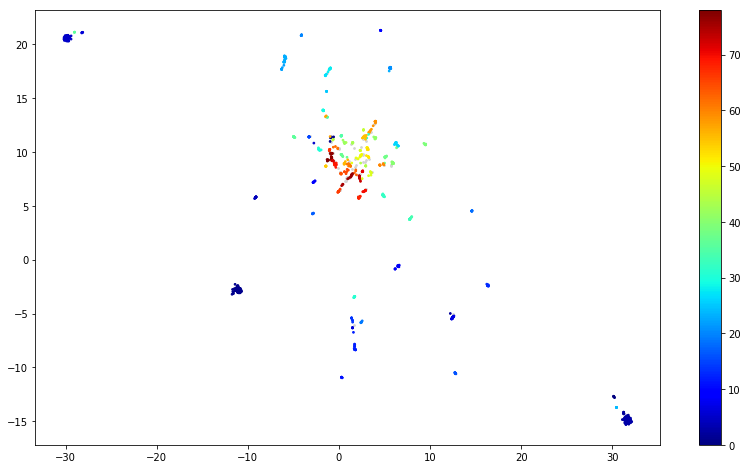

In [126]:
plot_clusters(embeddings_use, best_clusters_use)

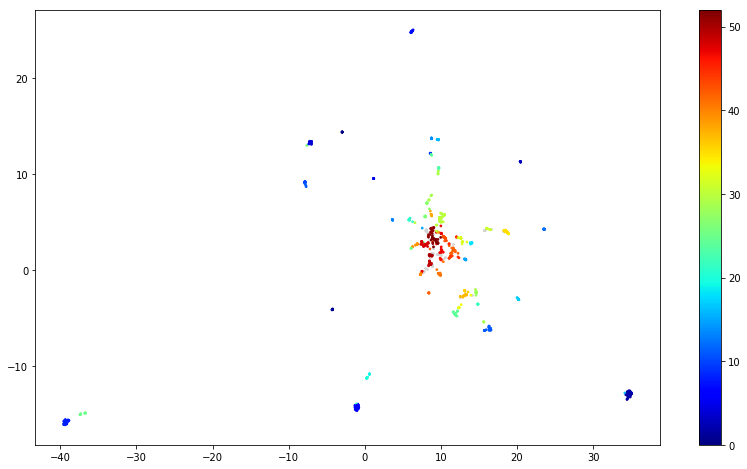

In [127]:
plot_clusters(embeddings_st1, best_clusters_st1)

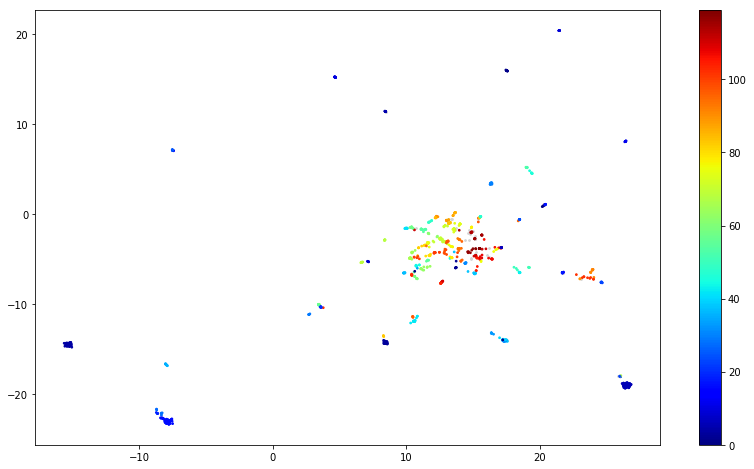

In [128]:
plot_clusters(embeddings_st2, best_clusters_st2)

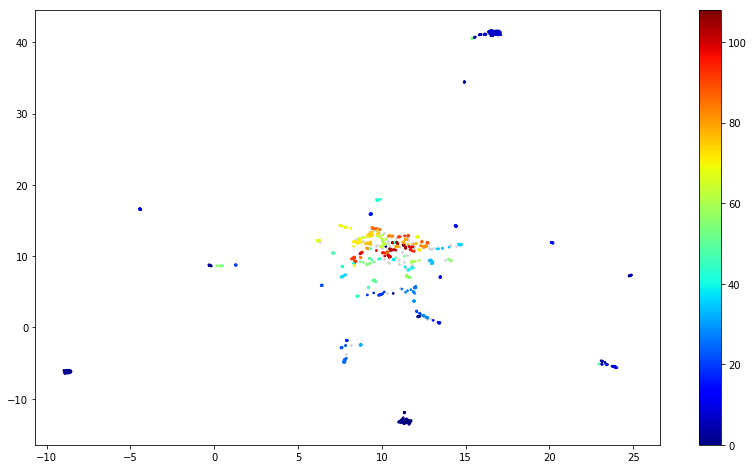

In [129]:
plot_clusters(embeddings_st3, best_clusters_st3)

### Compare clustering performance using ground truth labels

In [130]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st1, 
                'label_st2': best_clusters_st2,
                'label_st3': best_clusters_st3}

results_df = combine_results(data_sample[['0']], cluster_dict)
    
results_df.head()

,0,label_use,label_st1,label_st2,label_st3
0,place,1,6,16,0
1,Crust,57,21,105,-1
2,texture,-1,24,65,46
3,selection,24,25,35,20
4,menu,16,12,10,10


In [131]:
# model_dict = {'USE': ['label_use', best_params_use, trials_use],
#               'all-mpnet-base-v2': ['label_st1', best_params_st1, trials_st1],
#               'all-MiniLM-L6-v2': ['label_st2', best_params_st2, trials_st2],
#               'all-distilroberta-v1': ['label_st3', best_params_st3, trials_st3]
#                }

# summarize_results(model_dict, results_df)

The ARI and NMI generally, but don't perfectly, follwed the expected trends based on the calculated loss for each model.

### Manually inspect category consistency

In [132]:
results_df[results_df['label_st1']==-1]

,0,label_use,label_st1,label_st2,label_st3
12,cranberry,69,-1,93,65
14,signs,30,-1,63,50
31,salmon sashimi,58,-1,70,69
47,shrimp,55,-1,98,74
49,sides,35,-1,110,11
50,styrofoam,-1,-1,61,-1
54,register,30,-1,103,50
85,APPETIZERS,42,-1,97,27
98,rice,47,-1,83,97
109,Rice,47,-1,83,97


In [133]:
# st1_clusters = results_df.sort_values('label_st1')

In [134]:
temp = results_df.groupby('label_st1').agg(group=('0', ' '.join)).reset_index()

In [135]:
temp.group.to_list()

['cranberry signs salmon sashimi shrimp sides styrofoam register APPETIZERS rice Rice spring rolls tuna melt bathrooms Crostini egg rolls sides salmon tartar shower rolls bathrooms appetizers eggs ball rice appetizer gristle boiled shrimp sign crawfish cannoli sides shrimp entrees wedges family meal fried rice Panna Cotta grease mouths bite Dylan Han block sashimi Maine Lobster Roll bruschetta coconut shrimp bites butter bathroom entrees tuna sashimi Shrimp',
 'portions portion portions portion portions portions portions',
 'server servers server servers mains servers Server server servers server server server server server server server server servers server',
 'Service service Service service Service service service service Customer Service service Service service service service service service order serivce Service service service service service service service service service Service service Service service service Service service service service Service Service service Service s

In [109]:
key_phrases = [
    'service',
    'hygeine', 
    'appetizer', 
    'desserts',
    'drinks/bar', 
    'food',
    'entree', 
    'atmosphere', 
    'menu', 
    'price', 
    'manager']

In [110]:
key_phrases_embeddings_st1 = embed(model_st1, 'sentence transformer', key_phrases)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [82]:
embedding = embed(model_st1, 'sentence transformer', temp.group.to_list())

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [83]:
from numpy.linalg import norm
def cosine_sim(A,B):
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine

In [119]:
group = 21
print(temp.group.to_list()[group])
for i, phrase in enumerate(key_phrases_embeddings_st1):
    print(key_phrases[i])
    print(cosine_sim(phrase, embedding[group]))

discount value price priced price BARGAIN price deal priced value price price offers price price
service
0.19976914
hygeine
0.16195399
appetizer
0.12390313
desserts
0.16546719
drinks/bar
0.16208632
food
0.21842106
entree
0.16288562
atmosphere
0.2775354
menu
0.21578589
price
0.48189187
manager
0.16984005


Through manual inspection, it also appears as though sentence-transformer1 performs the best of the models considered.

### Save cluster results

In [51]:
results_df.to_csv('sample_clustered.csv')

In [52]:
results_df

,0,label_use,label_st1,label_st2,label_st3
0,place,1,12,24,6
1,Crust,99,29,75,89
2,texture,48,17,50,32
3,selection,55,33,47,46
4,menu,4,41,9,7
...,...,...,...,...,...
1183,texture,48,17,50,32
1184,Appetite,11,26,32,36
1185,experience,24,24,11,13
1186,Sushi,64,28,20,49
